In [1]:
import pandas as pd
import langid
import matplotlib.pyplot as plt
from datetime import datetime
from textblob import TextBlob

def parse_date(date_str):
    for fmt in ('%B %d, %Y', '%Y-%m-%d', '%m/%d/%Y'):  # Add any other formats you expect
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if no format matches

def is_english(text):
    pred = langid.classify(text)
    if pred[0] == 'en':
        return text
    return pd.NaT  # Return NaT if not in English

df_blind_R = pd.read_csv('../data/articles_blind_R.csv', index_col=0).drop(columns=["index"])
df_blind_D = pd.read_csv('../data/articles_blind_D.csv', index_col=0).drop(columns=["index"])
df_all = pd.read_csv('../data/articles.csv', index_col=0)

df_blind_R = df_blind_R.dropna()
df_blind_D = df_blind_D.dropna()
df_all = df_all.dropna()

df_all['date'] = df_all['date'].apply(parse_date)
df_all['text'] = df_all['text'].apply(is_english)
df_all = df_all.dropna()
df_all['date'] = df_all['date'].dt.strftime('%Y-%m-%d')

df_blind_R['date'] = df_blind_R['date'].apply(parse_date)
df_blind_R['text'] = df_blind_R['text'].apply(is_english)
df_blind_R = df_blind_R.dropna()
df_blind_R['date'] = df_blind_R['date'].dt.strftime('%Y-%m-%d')

df_blind_D['date'] = df_blind_D['date'].apply(parse_date)
df_blind_D['text'] = df_blind_D['text'].apply(is_english)
df_blind_D = df_blind_D.dropna()
df_blind_D['date'] = df_blind_D['date'].dt.strftime('%Y-%m-%d')

In [2]:
import re
def clean_up_text(text: str):
    if "[[" in text:
        return pd.NA
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\xa0", " ")
    text = text.replace("###", "")
    text = text.replace("# # #", "")
    text = text.replace("       Image     ", " ")
    text = re.sub(r"<{2,}", "", text)
    text = re.sub(r">{2,}", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [3]:
df_blind_R["text"] = df_blind_R["text"].apply(clean_up_text)
df_blind_R = df_blind_R.dropna()

df_blind_D["text"] = df_blind_D["text"].apply(clean_up_text)
df_blind_D = df_blind_D.dropna()

df_all["text"] = df_all["text"].apply(clean_up_text)
df_all = df_all.dropna()

### Text length

In [4]:
df_merged = pd.concat([df_blind_R, df_blind_D, df_all])
df_merged = df_merged.drop_duplicates(subset=['issue', 'title', 'date'])

df_merged["char_count"] = df_merged["text"].apply(lambda x: len(x))
df_filtered = df_merged[(df_merged["char_count"] > 150) & (df_merged["char_count"] < 10000)]

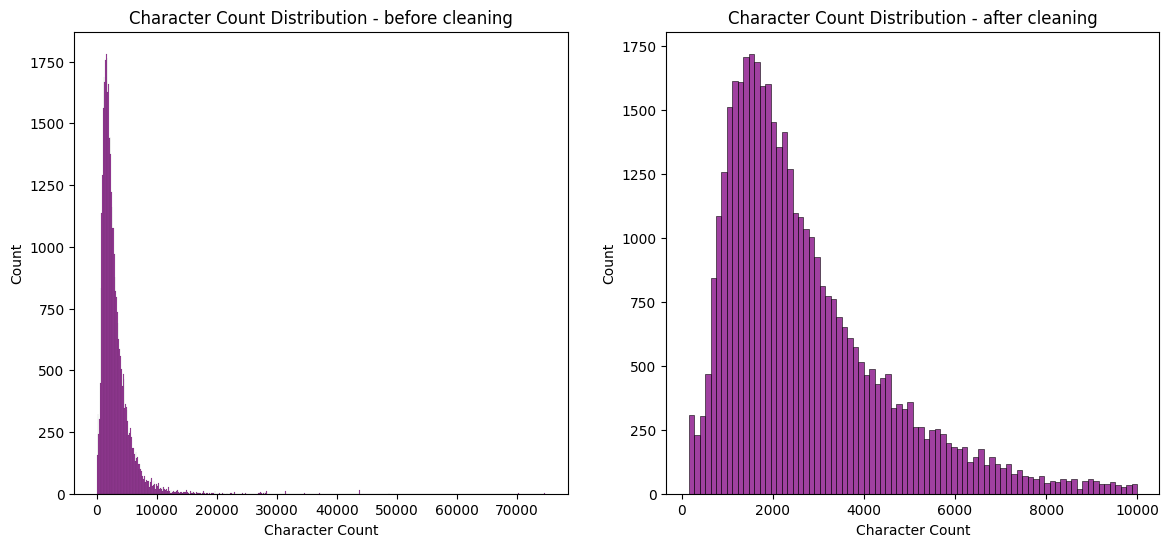

In [6]:
import seaborn as sns

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
sns.histplot(df_merged["char_count"], color="purple", ax = ax[0])
ax[0].set_title("Character Count Distribution - before cleaning")
ax[0].set_xlabel("Character Count")
sns.histplot(df_filtered["char_count"], color="purple", ax = ax[1])
ax[1].set_title("Character Count Distribution - after cleaning")
ax[1].set_xlabel("Character Count")

plt.savefig('../charts/characters_per_article.png')

In [6]:
df_blind_R["char_count"] = df_blind_R["text"].apply(lambda x: len(x))
df_blind_R_filtered = df_blind_R[(df_blind_R["char_count"] > 150) & (df_blind_R["char_count"] < 10000)]

df_blind_D["char_count"] = df_blind_D["text"].apply(lambda x: len(x))
df_blind_D_filtered = df_blind_D[(df_blind_D["char_count"] > 150) & (df_blind_D["char_count"] < 10000)]

df_all["char_count"] = df_all["text"].apply(lambda x: len(x))
df_all_filtered = df_all[(df_all["char_count"] > 150) & (df_all["char_count"] < 10000)]

In [11]:
df_merged.count()

issue                       42618
title                       42618
date                        42618
text                        42618
representative_name         42618
representative_state        42618
representative_party        42618
representative_committee    42618
char_count                  42618
dtype: int64

### Topic standarization

In [7]:
topics = {
    "Defense" : "National Security, Defence, Foreign Affairs",
    "Border Security": "National Security, Defence, Foreign Affairs",
    "Armed Services": "National Security, Defence, Foreign Affairs",
    "Connecticut’s Defense Industry": "National Security, Defence, Foreign Affairs",
    "Homeland Security": "National Security, Defence, Foreign Affairs",
    "Defense and National Security": "National Security, Defence, Foreign Affairs",
    "National Security": "National Security, Defence, Foreign Affairs",
    "Defense and Security": "National Security, Defence, Foreign Affairs",
    "What Rep. Flood is doing for the military and veterans": "National Security, Defence, Foreign Affairs",
    "Foreign Affairs": "National Security, Defence, Foreign Affairs",
				"Immigration": "National Security, Defence, Foreign Affairs",
    "Foreign Policy": "National Security, Defence, Foreign Affairs",
    "Defense and Foreign Affairs": "National Security, Defence, Foreign Affairs",
    "Defense & Security": "National Security, Defence, Foreign Affairs",
    "Defense/National Security": "National Security, Defence, Foreign Affairs",
    'National Defense': "National Security, Defence, Foreign Affairs",
			 'National Security and Foreign Affairs': "National Security, Defence, Foreign Affairs",
    'Illegal Immigration': "National Security, Defence, Foreign Affairs",
				'Immigration & Border Security': "National Security, Defence, Foreign Affairs",
				"Defense & National Security": "National Security, Defence, Foreign Affairs",
				'Homeland Security and Illegal Immigration': "National Security, Defence, Foreign Affairs",
				'Foreign Affairs & National Security': "National Security, Defence, Foreign Affairs",
    'Foreign Affairs and National Security': "National Security, Defence, Foreign Affairs",
    'Foreign Policy and National Security': "National Security, Defence, Foreign Affairs",
    'Securing the Border': "National Security, Defence, Foreign Affairs",
    'National Security and Foreign Policy': "National Security, Defence, Foreign Affairs",
    'Comprehensive Immigration Reform': "National Security, Defence, Foreign Affairs",
    
				"2nd Amendment Rights": "2nd Amendment and Gun Violence",
				"Second Amendment": "2nd Amendment and Gun Violence",
				"2nd Amendment": "2nd Amendment and Gun Violence",
				'Gun Rights': "2nd Amendment and Gun Violence",
				'Ending the Gun Violence Epidemic': "2nd Amendment and Gun Violence",
				'Gun Violence': "2nd Amendment and Gun Violence", 
				'Gun Violence Prevention':  "2nd Amendment and Gun Violence", 
				'Preventing Gun Violence':  "2nd Amendment and Gun Violence", 
                
				"Veterans Issues": "Veterans and Military",
				"Serving America's Veterans": "Veterans and Military",
				'Veterans and Military Retirees': "Veterans and Military",
				"Veterans": "Veterans and Military",
				'Veterans & Military Families': "Veterans and Military",
    'Veterans & Military Personnel': "Veterans and Military",
    'Blue Water Navy Vietnam Veterans Act': "Veterans and Military",
    'Agent Orange Exposure Fairness Act': "Veterans and Military",
    "Military Servicemembers and Veterans": "Veterans and Military",
    'Military & Veterans': "Veterans and Military",
    'Military and Veterans': "Veterans and Military",
    'Veterans and Military': "Veterans and Military", 
    'Veterans and Armed Forces': "Veterans and Military", 
				'Veterans and the Military': "Veterans and Military",
				'Service Members and Veterans': "Veterans and Military",
				'Armed Services and Veterans Affairs': "Veterans and Military",
				'Defending The Homeland': "Veterans and Military",
				'Veterans & Military Affairs': "Veterans and Military",
    'Veterans Affairs and Armed Services': "Veterans and Military",
     'Honoring Our Commitment To Our Veterans': "Veterans and Military",
     'Veterans & Armed Forces': "Veterans and Military",
    
    "Economy & Jobs (Small Business)": "Jobs and the Economy",
    "Economy and Jobs": "Jobs and the Economy",
    "Economy, Financial Services, & Trade": "Jobs and the Economy",
    "Business & Employers": "Jobs and the Economy",
    "Jobs & Workforce": "Jobs and the Economy",
    "Jobs and Workforce Development": "Jobs and the Economy",
    "Jobs and the Workforce": "Jobs and the Economy",
    "Economy": "Jobs and the Economy",
    "Inflation and the Economy": "Jobs and the Economy",
    "Building an Economy that Works for Everyone": "Jobs and the Economy",
    "Jobs & Economic Growth": "Jobs and the Economy",
    "Jobs, Economy & Small Businesses": "Jobs and the Economy",
    "Small Business": "Jobs and the Economy",
    "Small Business and Economy": "Jobs and the Economy",
    "Jobs and Economy": "Jobs and the Economy",
    "What Rep. Flood is doing to grow America’s economy": "Jobs and the Economy",
    "Jobs And The Economy": "Jobs and the Economy",
    "Jobs & Economy": "Jobs and the Economy",
    'Jobs and Economic Growth': "Jobs and the Economy",
    'Economic Policy': "Jobs and the Economy",
    'Economic Security': "Jobs and the Economy",
				'Economy & Job Creation': "Jobs and the Economy", 
    'Economy & Jobs': "Jobs and the Economy",
    'Supporting Small Businesses': "Jobs and the Economy",
    'An Economy for the Working Class': "Jobs and the Economy",
    'Growing Our Economy & Creating Jobs': "Jobs and the Economy",
    'Jobs, Small Business, and the Economy':'Jobs and the Economy',
    
				"Agriculture & Rural Development": "Agriculture",
    "Agriculture": "Agriculture",
    "Agriculture and Rural Affairs": "Agriculture",
    'Rural Priorities': "Agriculture",
    'Wine & Agriculture': "Agriculture",

    "Energy": "Energy and Environment",
    "Energy & Environment": "Energy and Environment",
    "Energy And Environment": "Energy and Environment",
    "Energy and Natural Resources": "Energy and Environment",
    "Energy and Environment": "Energy and Environment",
    "Environment": "Energy and Environment",
    "Natural Resources": "Energy and Environment",
    "Energy, Conservation, & Interior Department": "Energy and Environment",
    "Public Lands & Environment": "Energy and Environment",
    "Water": "Energy and Environment",
    "Forestry": "Energy and Environment",
    "Maritime": "Energy and Environment",
    "Fisheries": "Energy and Environment",
    "Offshore Drilling": "Energy and Environment",
    "California Water Crisis": "Energy and Environment",
    "Energy and the Environment": "Energy and Environment",
    'Clean Air/Clean Water': "Energy and Environment",
    'Clean Energy and Climate': "Energy and Environment",
    'Climate Change': "Energy and Environment", 
    'Combatting the Climate Crisis' : "Energy and Environment",
    'Protecting Our Environment' : "Energy and Environment",
    'Protecting Our Environment & Growing The Green Economy' : "Energy and Environment",
    'Energy Independence': "Energy and Environment",
    'Energy and Environment': "Energy and Environment", 
				'Environment & Energy': "Energy and Environment",
				'Reducing Emissions Through Green Jobs and Technology': "Energy and Environment",
    
				"Disaster Relief & Preparedness": "Disaster Relief & Preparedness",
    'Hurricane Preparedness' : "Disaster Relief & Preparedness",
				'Hurricane Preparedness and Recovery': "Disaster Relief & Preparedness",
				"Hurricane Recovery and Coastal Restoration": "Disaster Relief & Preparedness",
				'Flood Insurance': "Disaster Relief & Preparedness",

    "Tax Reform": "Federal Budget and Taxes",
				"Taxes and Spending": "Federal Budget and Taxes",
    "Federal Budget, Appropriations, & Taxes": "Federal Budget and Taxes",
    "Budget": "Federal Budget and Taxes",
    "Federal Spending and Borrowing": "Federal Budget and Taxes",
    "Fiscal Discipline": "Federal Budget and Taxes",
    "Fiscal Responsibility": "Federal Budget and Taxes",
    "Federal Budget, Jobs, & the Economy": "Federal Budget and Taxes",
    "Spending Cuts & Debt": "Federal Budget and Taxes",
    'Taxes': "Federal Budget and Taxes",
    "Budget and Spending": "Federal Budget and Taxes",
    "National Debt": "Federal Budget and Taxes",
    "Budget and Taxes": "Federal Budget and Taxes",
    'Tax Relief': "Federal Budget and Taxes",
    'Federal Budget': "Federal Budget and Taxes",
                
				"Health": "Health Care and Social Security", 
    "Healthcare": "Health Care and Social Security",
    "Healthcare, Social Security, & Support Programs": "Health Care and Social Security",
    "Social Security and Medicare": "Health Care and Social Security",
    "Improving Access to Affordable Healthcare": "Health Care and Social Security",
    "Social Security": "Health Care and Social Security",
    "Health Care": "Health Care and Social Security",
    "Making Health Care More Affordable": "Health Care and Social Security",
    "What Rep. Flood is doing to expand healthcare options": "Health Care and Social Security",
    "Disease of Addiction": "Health Care and Social Security",
    "Fighting the Opioid Crisis": "Health Care and Social Security",
    "Combating the Opioid Epidemic": "Health Care and Social Security",
    'Affordable Care Act': "Health Care and Social Security",
    'Lower Drug Costs Now Act': "Health Care and Social Security",
    'Lowering Health Care Costs': "Health Care and Social Security",
    'Medicare Buy-In and Health Care Stabilization Act': "Health Care and Social Security",
    'Protecting Public Health': "Health Care and Social Security",
    'Health Care and the Social Safety Net': "Health Care and Social Security",
    "Alzheimer's": "Health Care and Social Security",
    'Food, Drug, and Medical Device Safety': "Health Care and Social Security",
    'Price of Insulin': "Health Care and Social Security",
    
				"Senior Citizens": "Supporting Seniors",
    "Seniors": "Supporting Seniors",
    'Seniors and Retirement Security': "Supporting Seniors",
    "Seniors' Issues" : "Supporting Seniors",
    'Fighting for Seniors' : "Supporting Seniors",
    'Keeping Our Promises to Seniors': "Supporting Seniors",
                
				"Puerto Rico": "Local issues",
    "Connecticut Manufacturing": "Local issues",
    "Coltsville": "Local issues",
    'California': "Local issues",
			 'Community Safety': "Local issues",
				'Cuba': "Local issues",
    "Making Government Work for Kansans": "Local issues", 
    "Standing up for Local Communities": "Local issues", 
    "Building Our Communities": "Local issues", 
    "Community Groups & News": "Local issues", 
    "Reforming Washington": "Local issues", 
    "Lowering Costs and Strengthening Our Local Economy": "Local issues", 
    'Eastern Connecticut': "Local issues", 
    "Local Issues": "Local issues", 
    
				"Transportation": "Infrastructure and Transportation",
    "Infrastructure": "Infrastructure and Transportation",
    "Transportation & Infrastructure": "Infrastructure and Transportation",
    "Transportation and Infrastructure": "Infrastructure and Transportation",
    'Transportation Infrastructure': "Infrastructure and Transportation",

				"Congressional Issues": "Government and Law",
				"Congress": "Government and Law",
				"Law Enforcement": "Government and Law",
				"Judiciary": "Government and Law",
    "Oversight and Accountability": "Government and Law",
    "Delivering Results": "Government and Law",
    "Oversight and Reform": "Government and Law",
    "Supporting Law Enforcement": "Government and Law",
    "What Rep. Flood is doing in Congress": "Government and Law",
    'Government Regulation': "Government and Law",
    'Law & Order': "Government and Law",
    'Judiciary Issues/Oversight': "Government and Law",
    'Law Enforcement Reform': "Government and Law",
    'Legislative Action': "Government and Law",
    'Government Accountability and Transparency': "Government and Law", 
				'Government Reform': "Government and Law",
				'Legislation': "Government and Law",
     
                
				"Women": "Equality and Civil Rights",
				"Equality": "Equality and Civil Rights",
				"Law, Individual Rights, & Equality": "Equality and Civil Rights",
    "Rights & Freedoms": "Equality and Civil Rights",
				"Voting & Civil Rights": "Equality and Civil Rights",
    "Protecting the Right to Vote": "Equality and Civil Rights",
    "Election Integrity": "Equality and Civil Rights",
    "Voting Rights": "Equality and Civil Rights",
    "LGBTQ and Equality": "Equality and Civil Rights",
    "Reproductive Freedoms": "Equality and Civil Rights",
    "Civil Rights": "Equality and Civil Rights",
    'Civil Rights and Equality': "Equality and Civil Rights",
    'Civil Rights and Judiciary Issues': "Equality and Civil Rights",
    'Civil Rights and Women’s Issues': "Equality and Civil Rights", 
				'Civil and Human Rights': "Equality and Civil Rights",
				'Equality For All': 'Equality and Civil Rights',
    'Equality and Social Justice': "Equality and Civil Rights",
    'Expanding Protections for the LGBTQI+ Community': "Equality and Civil Rights",
    'Supporting Women': "Equality and Civil Rights", 
    "Upholding Civil Rights": "Equality and Civil Rights",
                
				"Education and Opportunity": "Education",
    "Expanding Educational Opportunities": "Education",
    "What Rep. Flood is doing to expand educational opportunities for families and kids": "Education",
    'Improving Education': "Education",
    'School Choice and Education': "Education",
    'Education & Our Kids': "Education",
    'Education and Student Loans': "Education",
    'Strengthening Education At Every Level': "Education",
    
				"Communication and Technology": "Science, Technology, & Telecommunications",
    "Finance & Technology": "Science, Technology, & Telecommunications",
    "Communications & Technology": "Science, Technology, & Telecommunications",
    'Technology & Innovation': "Science, Technology, & Telecommunications",
    'Science and Technology': 'Science, Technology, & Telecommunications',
    'Technology': 'Science, Technology, & Telecommunications',
    'Innovation and Technology': 'Science, Technology, & Telecommunications',
    'Internet and Technology': 'Science, Technology, & Telecommunications',
                
				"Family Values": "Pro-Life/Abortion and Family Values",
				"Pro-Life and Family Values": "Pro-Life/Abortion and Family Values",
				'Traditional Values and Pro-Life Efforts': "Pro-Life/Abortion and Family Values",
				'Right to Life': "Pro-Life/Abortion and Family Values",
				'Defending the Right to Abortion': "Pro-Life/Abortion and Family Values",
				'Reproductive Rights': "Pro-Life/Abortion and Family Values",
				'Restoring Reproductive Rights': "Pro-Life/Abortion and Family Values",
				
                
				"Housing and Community Development": "Housing",
				'Affordable Housing': "Housing",
				'Housing and Homelessness':"Housing",
				'Homelessness':"Housing",
				'Providing Safe, Affordable Housing for Every American':"Housing",
				'Resources for Homeowners':"Housing",
				
				"Constitutional Issues": "Constitution",
                
				"Back the Blue": "undef",
				"Crumbling Foundations": "undef",
    "Program Awards & Announcements": "undef",
    "Getting Things Done": "undef",
    "Public Service & Crime Prevention": "undef",
    "Financial Services": "undef",
    "Vice Chairman of Congressional Steel Caucus": "undef",
    "Supporting Organized Labor": "undef",
    "Ranking Member of House Veterans’ Affairs Subcommittee on Oversight and Investigations": "undef",
    "Congressional Steel Caucus": "undef",
    "Helping Families": "undef",
    "Life": "undef",
    "Education and Labor": "undef",
    "Native American Communities": "undef",
    "Congressman Larson's Committees": "undef",
    "Bills I've Sponsored/Co-Sponsored": "undef",
    "Public Lands": "undef",
   
    "Crime and Justice": "undef",
    "America's Workers": "undef",
    "Parris Island": "undef",
    "Spending": "undef",
    "What Rep. Flood is doing to grow American agriculture and energy": "undef",
}

undef = ['A Freedom Agenda for Congress', 'Accountability', 'Appropriations',
        'Environment, Energy Production, and Infrastructure',
       'Standing Up to the CCP', 'Support of Israel', 'Overregulation', 'Oversight', 
							'Everglades Restoration', 'Security', '43rd District', 'AUKUS News',
							'Africa', 'Democracy', 'Developing New Cures', 'District Projects',  'U.S. - Israel Relationship',
							 'Israel-Hamas War', 'Jobs & Education', 'Federal Spending and the Economy', 'Fiscal and Economic', 'Spending Cuts and Debt',
								'Veterans and Defense', 'Defense And Veterans', 'Animal Rights', 'Auto Safety',
       'Bipartisanship', 'COVID-19', 'Energía y medio ambiente',
       'Engagement with Additional Federal Agencies', 'FCC and Communications Policy',
       'Federal Appointments', 'Federal Resources to Eastern Connecticut',
       'Fighting for Immigrant Families', 'Flood Protection', 'Jobs, Economy and Federal Spending',
       'Campaign, Election, & Government Reform', 'Chicago',
       "Children's Product Safety", 'Commonsense Budgeting for All',
       'Community Event', 'Problem Solving and Bipartisanship',
       'Protecting Colorado’s Wilderness', 'Protecting Democracy',
       'Public Safety', 'Public Safety & Homeland Security',
       'Raising Wages for Working Families', 'Environment, Conservation, and Infrastructure',
								'Lower Costs for Coloradans',
       'Member-Designated Transportation Project Disclosure Page',
       'Faith and Religious Freedom',  'Healthy Families', 'Labor', 'Natural Resources Committee', 'Trade',
       'Consumer Protection',
       'Coronavirus', 'Costs', 'Criminal Justice',
       'Criminal Justice Reform and Gun Safety', 'Defending Democracy',
       'Diversity & Inclusion', 'Economy Taxes and Trade',
       'Human Services',
       'Information For Homeowners With Crumbling Foundations',
       'Infrastructure Investment and Jobs Act', 'American Dream and Promise Act',
       'Native Americans',
       'Opioid Crisis', 'Peace Building and Security', 'Postal Issues',
       'Seapower and Projection Forces Subcommittee',
       'Securing the Future', 'Seniors and Social Security',
       'Service Members and Defense', 'Standing Up For Working Families',
       'Repeal the Cadillac Tax', 'Taxes and Economy',
       'Workplace Violence Prevention For Healthcare And Social Service Workers Act',
       'Prioritizing Public Safety','Labor Issues', 'Justice & Civil Rights', 'Justice & Court Reform', 'Labor Issues',
       'Labor and Trade', 'Voting Rights and Campaign Finance Reform', 'Drug Crisis',
       'Law Enforcement and Community Safety',  'Military, Veterans, & National Security',
       'National Security and Veterans',
							]

In [8]:
print(len(topics.keys())+len(undef))

358


In [8]:
import numpy as np

def standardize_topic(topic: str):
    if topic in undef:
        return "undef"
    return topics.get(topic, topic)
np.unique(df_blind_R_filtered["issue"].transform(standardize_topic).to_list())

array(['2nd Amendment and Gun Violence', 'Agriculture', 'Constitution',
       'Disaster Relief & Preparedness', 'Education',
       'Energy and Environment', 'Equality and Civil Rights',
       'Federal Budget and Taxes', 'Government and Law',
       'Health Care and Social Security',
       'Infrastructure and Transportation', 'Jobs and the Economy',
       'Local issues', 'National Security, Defence, Foreign Affairs',
       'Pro-Life/Abortion and Family Values',
       'Science, Technology, & Telecommunications', 'Supporting Seniors',
       'Veterans and Military', 'undef'], dtype='<U43')

In [9]:
np.unique(df_all_filtered["issue"].transform(standardize_topic).to_list())

array(['2nd Amendment and Gun Violence', 'Agriculture', 'Constitution',
       'Disaster Relief & Preparedness', 'Education',
       'Energy and Environment', 'Equality and Civil Rights',
       'Federal Budget and Taxes', 'Government and Law',
       'Health Care and Social Security', 'Housing',
       'Infrastructure and Transportation', 'Jobs and the Economy',
       'Local issues', 'National Security, Defence, Foreign Affairs',
       'Pro-Life/Abortion and Family Values',
       'Science, Technology, & Telecommunications', 'Supporting Seniors',
       'Veterans and Military', 'undef'], dtype='<U43')

In [10]:
df_blind_D_filtered["issue"] = df_blind_D_filtered["issue"].apply(standardize_topic)
df_blind_D_filtered = df_blind_D_filtered[df_blind_D_filtered["issue"] != "undef"]
df_blind_D_filtered = df_blind_D_filtered.dropna()
df_blind_D_filtered = df_blind_D_filtered.reset_index(drop=True)
df_blind_D_filtered = df_blind_D_filtered.drop_duplicates(subset=['issue', 'title', 'date']) #Remove duplicates created after mapping.


df_blind_R_filtered["issue"] = df_blind_R_filtered["issue"].apply(standardize_topic)
df_blind_R_filtered = df_blind_R_filtered[df_blind_R_filtered["issue"] != "undef"]
df_blind_R_filtered = df_blind_R_filtered.dropna()
df_blind_R_filtered = df_blind_R_filtered.reset_index(drop=True)
df_blind_R_filtered = df_blind_R_filtered.drop_duplicates(subset=['issue', 'title', 'date'])

df_all_filtered["issue"] = df_all_filtered["issue"].apply(standardize_topic)
df_all_filtered = df_all_filtered[df_all_filtered["issue"] != "undef"]
df_all_filtered = df_all_filtered.dropna()
df_all_filtered = df_all_filtered.reset_index(drop=True)
df_all_filtered = df_all_filtered.drop_duplicates(subset=['issue', 'title', 'date'])

/tmp/ipykernel_9104/2076279797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blind_D_filtered["issue"] = df_blind_D_filtered["issue"].apply(standardize_topic)
/tmp/ipykernel_9104/2076279797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blind_R_filtered["issue"] = df_blind_R_filtered["issue"].apply(standardize_topic)
/tmp/ipykernel_9104/2076279797.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [12]:
df_merged = pd.concat([df_blind_R_filtered, df_blind_D_filtered, df_all_filtered])
df_merged = df_merged.drop_duplicates(subset=['issue', 'title', 'date'])
df_merged.to_csv('../data/cleaned_all_articles.csv') 
df_merged["issue"].value_counts()[:15]

issue
National Security, Defence, Foreign Affairs    5126
Health Care and Social Security                4601
Jobs and the Economy                           4584
Energy and Environment                         3771
Education                                      2450
Veterans and Military                          2303
Government and Law                             2175
Local issues                                   1736
Agriculture                                    1665
Federal Budget and Taxes                       1526
Infrastructure and Transportation              1383
Equality and Civil Rights                       760
Science, Technology, & Telecommunications       577
Supporting Seniors                              431
2nd Amendment and Gun Violence                  358
Name: count, dtype: int64

In [13]:
df_merged["representative_name"].value_counts()[:40]

representative_name
Bishop, Sanford              2710
Panetta, Jimmy               1544
Courtney, Joe                1466
Miller-Meeks, Mariannette    1455
Khanna, Ro                   1359
Thompson, Mike               1324
Johnson, Henry               1125
LaMalfa, Doug                 956
Radewagen, Aumua Amata        916
Matsui, Doris                 908
McCollum, Betty               829
Smith, Adrian                 813
Davids, Sharice               813
Craig, Angie                  725
Larson, John                  715
Ruiz, Raul                    650
Norcross, Donald              628
Boebert, Lauren               623
Lamborn, Doug                 621
Harris, Andy                  590
Westerman, Bruce              555
Diaz-Balart, Mario            551
Garcia, Jesus                 549
DeLauro, Rosa                 533
Pocan, Mark                   470
Napolitano, Grace             455
Ruppersberger, C.             446
Palmer, Gary                  446
Bost, Mike                  

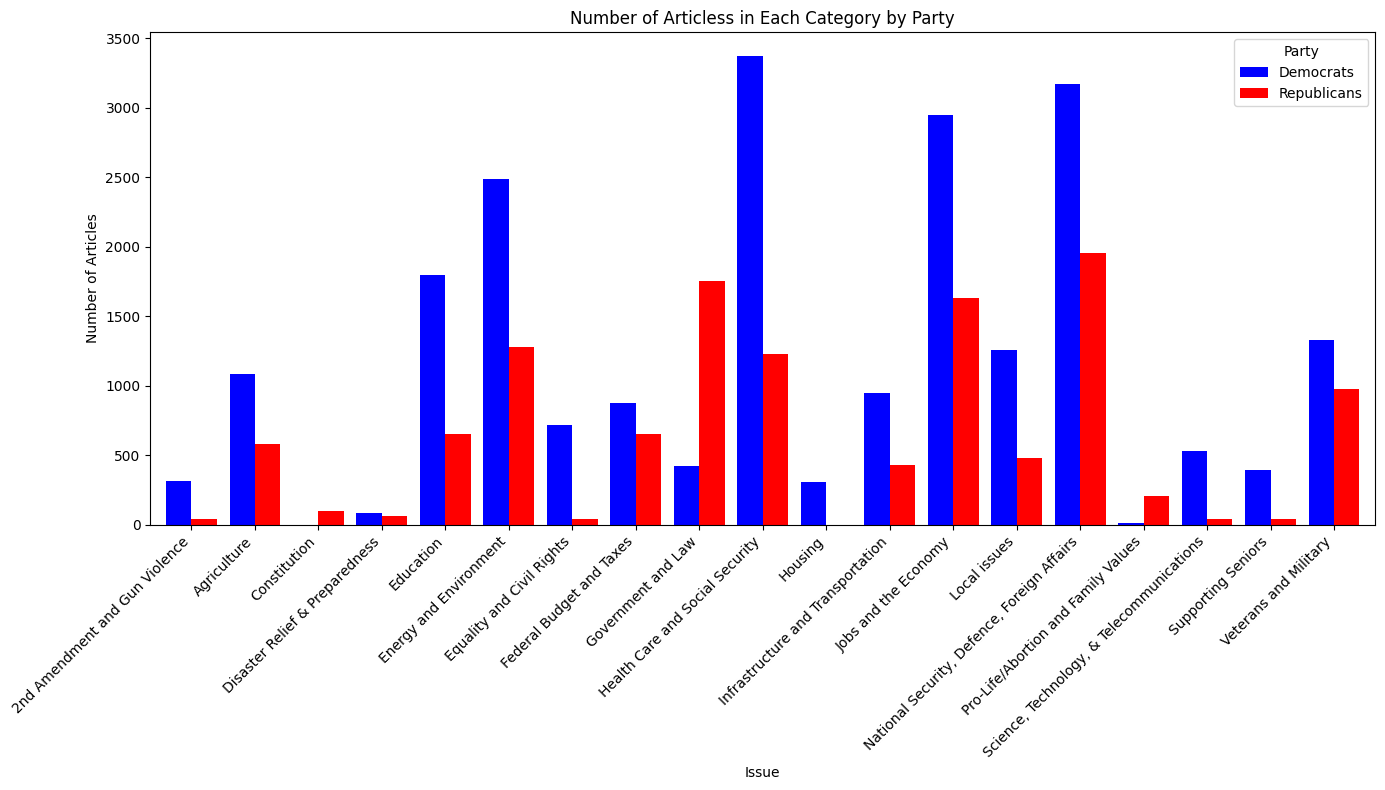

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

col_list_D = df_merged.loc[df_merged['representative_party'] == 'D']['issue'].values.tolist()
col_list_R = df_merged.loc[df_merged['representative_party'] == 'R']['issue'].values.tolist()

committee_counts_D = pd.Series(col_list_D).value_counts()
committee_counts_R = pd.Series(col_list_R).value_counts()

# Combine counts into a single DataFrame
committee_counts = pd.DataFrame({
    'Democrats': committee_counts_D,
    'Republicans': committee_counts_R
}).fillna(0)  # Fill NaN values with 0

# Plot the bar chart
bar_colors = ['blue', 'red']
committee_counts.plot(kind='bar', figsize=(14, 8), width=0.8, color=bar_colors)
plt.xlabel('Issue')
plt.ylabel('Number of Articles')
plt.title('Number of Articless in Each Category by Party')
plt.legend(title='Party')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('./articles_per_issue.png')

plt.show()

In [15]:
def merge_duplicates(group):
    issues = ';'.join(group['issue'].tolist())
    new_row = group.iloc[0].copy()
    new_row['issue'] = issues
    return new_row

df_merged = df_merged.groupby(['title', 'date', 'representative_name']).apply(merge_duplicates).reset_index(drop=True)
df_merged.drop(["char_count"], axis=1).to_csv('../data/cleaned_merged_all_articles.csv')
print("Number of rows in the DataFrame:", df_merged.shape[0])

/tmp/ipykernel_9104/3891220034.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby(['title', 'date', 'representative_name']).apply(merge_duplicates).reset_index(drop=True)


Number of rows in the DataFrame: 25644


25652